## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-10-09 04:12:03--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  58.8MB/s    in 5.3s    

2019-10-09 04:12:09 (60.9 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=86528, out_features=544, bias=True)
  (fc2): Linear(in_features=544, out_features=272, bias=True)
  (fc3): Linear(in_features=272, out_features=136, bias=True)
  (dropout): Dropout(p=0.25)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.transforms.Compose([
    Rescale(250),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

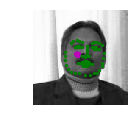

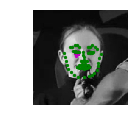

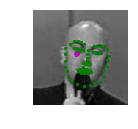

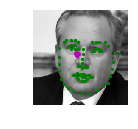

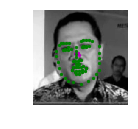

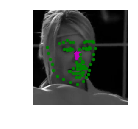

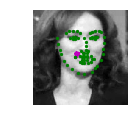

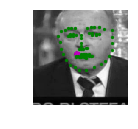

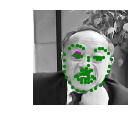

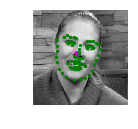

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 8 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.3265351042151451
Epoch: 1, Batch: 20, Avg. Loss: 0.18168289959430695
Epoch: 1, Batch: 30, Avg. Loss: 0.17312900573015214
Epoch: 1, Batch: 40, Avg. Loss: 0.14295794442296028
Epoch: 1, Batch: 50, Avg. Loss: 0.1307283379137516
Epoch: 1, Batch: 60, Avg. Loss: 0.13849516361951827
Epoch: 1, Batch: 70, Avg. Loss: 0.12288595288991928
Epoch: 1, Batch: 80, Avg. Loss: 0.12025629431009292
Epoch: 1, Batch: 90, Avg. Loss: 0.11087527126073837
Epoch: 1, Batch: 100, Avg. Loss: 0.12316850274801254
Epoch: 1, Batch: 110, Avg. Loss: 0.09824957326054573
Epoch: 1, Batch: 120, Avg. Loss: 0.12297858521342278
Epoch: 1, Batch: 130, Avg. Loss: 0.11609900817275047
Epoch: 1, Batch: 140, Avg. Loss: 0.12046224847435952
Epoch: 1, Batch: 150, Avg. Loss: 0.10775745064020156
Epoch: 1, Batch: 160, Avg. Loss: 0.12265321314334869
Epoch: 1, Batch: 170, Avg. Loss: 0.12304294407367707
Epoch: 1, Batch: 180, Avg. Loss: 0.09729624390602112
Epoch: 1, Batch: 190, Avg. Loss: 0.10148592367768287
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.1011854350566864
Epoch: 2, Batch: 20, Avg. Loss: 0.1021309643983841
Epoch: 2, Batch: 30, Avg. Loss: 0.11374243944883347
Epoch: 2, Batch: 40, Avg. Loss: 0.1271042563021183
Epoch: 2, Batch: 50, Avg. Loss: 0.1078442931175232
Epoch: 2, Batch: 60, Avg. Loss: 0.10257876068353652
Epoch: 2, Batch: 70, Avg. Loss: 0.10851116329431534
Epoch: 2, Batch: 80, Avg. Loss: 0.11224747523665428
Epoch: 2, Batch: 90, Avg. Loss: 0.09596847593784333
Epoch: 2, Batch: 100, Avg. Loss: 0.10450998842716216
Epoch: 2, Batch: 110, Avg. Loss: 0.09269574359059334
Epoch: 2, Batch: 120, Avg. Loss: 0.10561684370040894
Epoch: 2, Batch: 130, Avg. Loss: 0.11322432681918145
Epoch: 2, Batch: 140, Avg. Loss: 0.10397225916385651
Epoch: 2, Batch: 150, Avg. Loss: 0.09218104556202888
Epoch: 2, Batch: 160, Avg. Loss: 0.09311759173870086
Epoch: 2, Batch: 170, Avg. Loss: 0.09603050276637078
Epoch: 2, Batch: 180, Avg. Loss: 0.09075086191296577
Epoch: 2, Batch: 190, Avg. Loss: 0.09945365265011788
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.10917215794324875
Epoch: 3, Batch: 20, Avg. Loss: 0.09541700854897499
Epoch: 3, Batch: 30, Avg. Loss: 0.11517273038625717
Epoch: 3, Batch: 40, Avg. Loss: 0.10259260162711144
Epoch: 3, Batch: 50, Avg. Loss: 0.09627801850438118
Epoch: 3, Batch: 60, Avg. Loss: 0.11517664045095444
Epoch: 3, Batch: 70, Avg. Loss: 0.08984307721257209
Epoch: 3, Batch: 80, Avg. Loss: 0.09654823467135429
Epoch: 3, Batch: 90, Avg. Loss: 0.0890125460922718
Epoch: 3, Batch: 100, Avg. Loss: 0.09038403443992138
Epoch: 3, Batch: 110, Avg. Loss: 0.09354956522583961
Epoch: 3, Batch: 120, Avg. Loss: 0.09560386463999748
Epoch: 3, Batch: 130, Avg. Loss: 0.09261512830853462
Epoch: 3, Batch: 140, Avg. Loss: 0.09747519120573997
Epoch: 3, Batch: 150, Avg. Loss: 0.085405333340168
Epoch: 3, Batch: 160, Avg. Loss: 0.08835381232202053
Epoch: 3, Batch: 170, Avg. Loss: 0.08957479670643806
Epoch: 3, Batch: 180, Avg. Loss: 0.09239182844758034
Epoch: 3, Batch: 190, Avg. Loss: 0.08817914128303528
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.09915907606482506
Epoch: 4, Batch: 20, Avg. Loss: 0.09725957736372948
Epoch: 4, Batch: 30, Avg. Loss: 0.0938252791762352
Epoch: 4, Batch: 40, Avg. Loss: 0.1001935951411724
Epoch: 4, Batch: 50, Avg. Loss: 0.0915535107254982
Epoch: 4, Batch: 60, Avg. Loss: 0.1087727665901184
Epoch: 4, Batch: 70, Avg. Loss: 0.08936524540185928
Epoch: 4, Batch: 80, Avg. Loss: 0.0893116757273674
Epoch: 4, Batch: 90, Avg. Loss: 0.08330883458256721
Epoch: 4, Batch: 100, Avg. Loss: 0.09268767088651657
Epoch: 4, Batch: 110, Avg. Loss: 0.10295485481619834
Epoch: 4, Batch: 120, Avg. Loss: 0.09719564169645309
Epoch: 4, Batch: 130, Avg. Loss: 0.08791884779930115
Epoch: 4, Batch: 140, Avg. Loss: 0.10308361127972603
Epoch: 4, Batch: 150, Avg. Loss: 0.09070673361420631
Epoch: 4, Batch: 160, Avg. Loss: 0.09974759668111802
Epoch: 4, Batch: 170, Avg. Loss: 0.09052111208438873
Epoch: 4, Batch: 180, Avg. Loss: 0.08101566135883331
Epoch: 4, Batch: 190, Avg. Loss: 0.09001878425478935
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.10161005333065987
Epoch: 5, Batch: 20, Avg. Loss: 0.10489890128374099
Epoch: 5, Batch: 30, Avg. Loss: 0.09151028916239738
Epoch: 5, Batch: 40, Avg. Loss: 0.10388675630092621
Epoch: 5, Batch: 50, Avg. Loss: 0.08420532941818237
Epoch: 5, Batch: 60, Avg. Loss: 0.09629523530602455
Epoch: 5, Batch: 70, Avg. Loss: 0.09615048095583915
Epoch: 5, Batch: 80, Avg. Loss: 0.09195855483412743
Epoch: 5, Batch: 90, Avg. Loss: 0.0903319887816906
Epoch: 5, Batch: 100, Avg. Loss: 0.09262488037347794
Epoch: 5, Batch: 110, Avg. Loss: 0.089165810495615
Epoch: 5, Batch: 120, Avg. Loss: 0.0900187186896801
Epoch: 5, Batch: 130, Avg. Loss: 0.09707376584410668
Epoch: 5, Batch: 140, Avg. Loss: 0.09726862907409668
Epoch: 5, Batch: 150, Avg. Loss: 0.09206068180501462
Epoch: 5, Batch: 160, Avg. Loss: 0.08838671892881393
Epoch: 5, Batch: 170, Avg. Loss: 0.08065333366394042
Epoch: 5, Batch: 180, Avg. Loss: 0.08765163496136666
Epoch: 5, Batch: 190, Avg. Loss: 0.08729515075683594
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.09346413016319274
Epoch: 6, Batch: 20, Avg. Loss: 0.08588707968592643
Epoch: 6, Batch: 30, Avg. Loss: 0.09150195792317391
Epoch: 6, Batch: 40, Avg. Loss: 0.10108025819063186
Epoch: 6, Batch: 50, Avg. Loss: 0.08699661120772362
Epoch: 6, Batch: 60, Avg. Loss: 0.08777679055929184
Epoch: 6, Batch: 70, Avg. Loss: 0.08601529374718667
Epoch: 6, Batch: 80, Avg. Loss: 0.08843863904476165
Epoch: 6, Batch: 90, Avg. Loss: 0.08919055312871933
Epoch: 6, Batch: 100, Avg. Loss: 0.09515157118439674
Epoch: 6, Batch: 110, Avg. Loss: 0.10108985602855683
Epoch: 6, Batch: 120, Avg. Loss: 0.08557480871677399
Epoch: 6, Batch: 130, Avg. Loss: 0.08377788215875626
Epoch: 6, Batch: 140, Avg. Loss: 0.09012788236141205
Epoch: 6, Batch: 150, Avg. Loss: 0.09371153563261032
Epoch: 6, Batch: 160, Avg. Loss: 0.08791584819555283
Epoch: 6, Batch: 170, Avg. Loss: 0.06818932630121707
Epoch: 6, Batch: 180, Avg. Loss: 0.08385478779673576
Epoch: 6, Batch: 190, Avg. Loss: 0.0843899417668581
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.08025989830493926
Epoch: 7, Batch: 20, Avg. Loss: 0.09976560324430465
Epoch: 7, Batch: 30, Avg. Loss: 0.09488781616091728
Epoch: 7, Batch: 40, Avg. Loss: 0.07945876605808735
Epoch: 7, Batch: 50, Avg. Loss: 0.06990208216011524
Epoch: 7, Batch: 60, Avg. Loss: 0.09274820759892463
Epoch: 7, Batch: 70, Avg. Loss: 0.08629176132380963
Epoch: 7, Batch: 80, Avg. Loss: 0.08251727521419525
Epoch: 7, Batch: 90, Avg. Loss: 0.07504346258938313
Epoch: 7, Batch: 100, Avg. Loss: 0.07941817045211792
Epoch: 7, Batch: 110, Avg. Loss: 0.0828948438167572
Epoch: 7, Batch: 120, Avg. Loss: 0.08072746694087982
Epoch: 7, Batch: 130, Avg. Loss: 0.07617193646728992
Epoch: 7, Batch: 140, Avg. Loss: 0.09882298782467842
Epoch: 7, Batch: 150, Avg. Loss: 0.07836028002202511
Epoch: 7, Batch: 160, Avg. Loss: 0.08303848877549172
Epoch: 7, Batch: 170, Avg. Loss: 0.08455414175987244
Epoch: 7, Batch: 180, Avg. Loss: 0.0870724581182003
Epoch: 7, Batch: 190, Avg. Loss: 0.08304250314831733
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.08637143597006798
Epoch: 8, Batch: 20, Avg. Loss: 0.08552418313920498
Epoch: 8, Batch: 30, Avg. Loss: 0.07303879894316197
Epoch: 8, Batch: 40, Avg. Loss: 0.08820613995194435
Epoch: 8, Batch: 50, Avg. Loss: 0.0866835318505764
Epoch: 8, Batch: 60, Avg. Loss: 0.08989078998565674
Epoch: 8, Batch: 70, Avg. Loss: 0.08308490216732026
Epoch: 8, Batch: 80, Avg. Loss: 0.0801638551056385
Epoch: 8, Batch: 90, Avg. Loss: 0.07931654788553714
Epoch: 8, Batch: 100, Avg. Loss: 0.0878476470708847
Epoch: 8, Batch: 110, Avg. Loss: 0.08643327355384826
Epoch: 8, Batch: 120, Avg. Loss: 0.09301185458898545
Epoch: 8, Batch: 130, Avg. Loss: 0.08701838515698909
Epoch: 8, Batch: 140, Avg. Loss: 0.08252923414111138
Epoch: 8, Batch: 150, Avg. Loss: 0.08081216774880887
Epoch: 8, Batch: 160, Avg. Loss: 0.0774797759950161
Epoch: 8, Batch: 170, Avg. Loss: 0.08866912312805653
Epoch: 8, Batch: 180, Avg. Loss: 0.08077793493866921
Epoch: 8, Batch: 190, Avg. Loss: 0.08080079890787602
Epoch:

In [ ]:
net.load_state_dict(torch.load('saved_models/keypoints_model_4.pt'))

In [19]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.08615174368023873
Epoch: 1, Batch: 20, Avg. Loss: 0.07657205015420913
Epoch: 1, Batch: 30, Avg. Loss: 0.07653646506369113
Epoch: 1, Batch: 40, Avg. Loss: 0.07164775170385837
Epoch: 1, Batch: 50, Avg. Loss: 0.07292606346309186
Epoch: 1, Batch: 60, Avg. Loss: 0.07547753006219864
Epoch: 1, Batch: 70, Avg. Loss: 0.07948040813207627
Epoch: 1, Batch: 80, Avg. Loss: 0.08698066473007202
Epoch: 1, Batch: 90, Avg. Loss: 0.08158341571688651
Epoch: 1, Batch: 100, Avg. Loss: 0.07410661987960339
Epoch: 1, Batch: 110, Avg. Loss: 0.08518005646765232
Epoch: 1, Batch: 120, Avg. Loss: 0.08147693872451782
Epoch: 1, Batch: 130, Avg. Loss: 0.09000839516520501
Epoch: 1, Batch: 140, Avg. Loss: 0.09875270687043666
Epoch: 1, Batch: 150, Avg. Loss: 0.07077297531068324
Epoch: 1, Batch: 160, Avg. Loss: 0.0739108096808195
Epoch: 1, Batch: 170, Avg. Loss: 0.08719341307878495
Epoch: 1, Batch: 180, Avg. Loss: 0.07237223349511623
Epoch: 1, Batch: 190, Avg. Loss: 0.07226653471589088
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.0894348867237568
Epoch: 2, Batch: 20, Avg. Loss: 0.07133160457015038
Epoch: 2, Batch: 30, Avg. Loss: 0.08432590551674365
Epoch: 2, Batch: 40, Avg. Loss: 0.07965731173753739
Epoch: 2, Batch: 50, Avg. Loss: 0.08299470357596875
Epoch: 2, Batch: 60, Avg. Loss: 0.09226865768432617
Epoch: 2, Batch: 70, Avg. Loss: 0.07543109841644764
Epoch: 2, Batch: 80, Avg. Loss: 0.07668628171086311
Epoch: 2, Batch: 90, Avg. Loss: 0.07500912733376026
Epoch: 2, Batch: 100, Avg. Loss: 0.08976363241672516
Epoch: 2, Batch: 110, Avg. Loss: 0.07995506078004837
Epoch: 2, Batch: 120, Avg. Loss: 0.09053858034312726
Epoch: 2, Batch: 130, Avg. Loss: 0.07457976527512074
Epoch: 2, Batch: 140, Avg. Loss: 0.08198338598012925
Epoch: 2, Batch: 150, Avg. Loss: 0.0705502338707447
Epoch: 2, Batch: 160, Avg. Loss: 0.09936080053448677
Epoch: 2, Batch: 170, Avg. Loss: 0.08617975562810898
Epoch: 2, Batch: 180, Avg. Loss: 0.08111025914549827
Epoch: 2, Batch: 190, Avg. Loss: 0.08086229972541333
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.08613138049840927
Epoch: 3, Batch: 20, Avg. Loss: 0.08290238007903099
Epoch: 3, Batch: 30, Avg. Loss: 0.08546321205794812
Epoch: 3, Batch: 40, Avg. Loss: 0.07669726274907589
Epoch: 3, Batch: 50, Avg. Loss: 0.07633655667304992
Epoch: 3, Batch: 60, Avg. Loss: 0.08146588131785393
Epoch: 3, Batch: 70, Avg. Loss: 0.09294572249054908
Epoch: 3, Batch: 80, Avg. Loss: 0.0918906457722187
Epoch: 3, Batch: 90, Avg. Loss: 0.07749452814459801
Epoch: 3, Batch: 100, Avg. Loss: 0.07896067127585411
Epoch: 3, Batch: 110, Avg. Loss: 0.07837674841284752
Epoch: 3, Batch: 120, Avg. Loss: 0.0789852723479271
Epoch: 3, Batch: 130, Avg. Loss: 0.07614320404827594
Epoch: 3, Batch: 140, Avg. Loss: 0.0816651776432991
Epoch: 3, Batch: 150, Avg. Loss: 0.08877194076776504
Epoch: 3, Batch: 160, Avg. Loss: 0.06928639225661755
Epoch: 3, Batch: 170, Avg. Loss: 0.07745573967695236
Epoch: 3, Batch: 180, Avg. Loss: 0.0757700938731432
Epoch: 3, Batch: 190, Avg. Loss: 0.07187255658209324
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.07725821472704411
Epoch: 4, Batch: 20, Avg. Loss: 0.08417004905641079
Epoch: 4, Batch: 30, Avg. Loss: 0.07473862543702126
Epoch: 4, Batch: 40, Avg. Loss: 0.07078213803470135
Epoch: 4, Batch: 50, Avg. Loss: 0.07278132885694504
Epoch: 4, Batch: 60, Avg. Loss: 0.07709750942885876
Epoch: 4, Batch: 70, Avg. Loss: 0.08981067650020122
Epoch: 4, Batch: 80, Avg. Loss: 0.06749985814094543
Epoch: 4, Batch: 90, Avg. Loss: 0.07627294920384883
Epoch: 4, Batch: 100, Avg. Loss: 0.07846013531088829
Epoch: 4, Batch: 110, Avg. Loss: 0.0807279922068119
Epoch: 4, Batch: 120, Avg. Loss: 0.07532369829714299
Epoch: 4, Batch: 130, Avg. Loss: 0.0780721515417099
Epoch: 4, Batch: 140, Avg. Loss: 0.0704254612326622
Epoch: 4, Batch: 150, Avg. Loss: 0.06394431553781033
Epoch: 4, Batch: 160, Avg. Loss: 0.07061445415019989
Epoch: 4, Batch: 170, Avg. Loss: 0.06867000721395015
Epoch: 4, Batch: 180, Avg. Loss: 0.07977207563817501
Epoch: 4, Batch: 190, Avg. Loss: 0.08035313449800015
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.08230301216244698
Epoch: 5, Batch: 20, Avg. Loss: 0.07150353528559208
Epoch: 5, Batch: 30, Avg. Loss: 0.07244586162269115
Epoch: 5, Batch: 40, Avg. Loss: 0.06499209813773632
Epoch: 5, Batch: 50, Avg. Loss: 0.06251181028783322
Epoch: 5, Batch: 60, Avg. Loss: 0.07658324465155601
Epoch: 5, Batch: 70, Avg. Loss: 0.07239756658673287
Epoch: 5, Batch: 80, Avg. Loss: 0.08903902284801006
Epoch: 5, Batch: 90, Avg. Loss: 0.07225782051682472
Epoch: 5, Batch: 100, Avg. Loss: 0.07572414763271809
Epoch: 5, Batch: 110, Avg. Loss: 0.07255437560379505
Epoch: 5, Batch: 120, Avg. Loss: 0.0810781940817833
Epoch: 5, Batch: 130, Avg. Loss: 0.07797776833176613
Epoch: 5, Batch: 140, Avg. Loss: 0.06752262338995933
Epoch: 5, Batch: 150, Avg. Loss: 0.07228901386260986
Epoch: 5, Batch: 160, Avg. Loss: 0.07156961373984813
Epoch: 5, Batch: 170, Avg. Loss: 0.0744608175009489
Epoch: 5, Batch: 180, Avg. Loss: 0.07475857101380826
Epoch: 5, Batch: 190, Avg. Loss: 0.07277987748384476
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.07714515998959541
Epoch: 6, Batch: 20, Avg. Loss: 0.07218906432390212
Epoch: 6, Batch: 30, Avg. Loss: 0.07688615769147873
Epoch: 6, Batch: 40, Avg. Loss: 0.0743734285235405
Epoch: 6, Batch: 50, Avg. Loss: 0.07315243780612946
Epoch: 6, Batch: 60, Avg. Loss: 0.08119710832834244
Epoch: 6, Batch: 70, Avg. Loss: 0.06948517523705959
Epoch: 6, Batch: 80, Avg. Loss: 0.07024959437549114
Epoch: 6, Batch: 90, Avg. Loss: 0.08250645957887173
Epoch: 6, Batch: 100, Avg. Loss: 0.07297951877117156
Epoch: 6, Batch: 110, Avg. Loss: 0.07947408780455589
Epoch: 6, Batch: 120, Avg. Loss: 0.06928826421499253
Epoch: 6, Batch: 130, Avg. Loss: 0.07610117569565773
Epoch: 6, Batch: 140, Avg. Loss: 0.07026547938585281
Epoch: 6, Batch: 150, Avg. Loss: 0.0709163922816515
Epoch: 6, Batch: 160, Avg. Loss: 0.08313780091702938
Epoch: 6, Batch: 170, Avg. Loss: 0.06827810630202294
Epoch: 6, Batch: 180, Avg. Loss: 0.07086122967302799
Epoch: 6, Batch: 190, Avg. Loss: 0.06258880943059922
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.06508175507187844
Epoch: 7, Batch: 20, Avg. Loss: 0.0713237252086401
Epoch: 7, Batch: 30, Avg. Loss: 0.08778553009033203
Epoch: 7, Batch: 40, Avg. Loss: 0.061852022632956506
Epoch: 7, Batch: 50, Avg. Loss: 0.06649943254888058
Epoch: 7, Batch: 60, Avg. Loss: 0.08094465360045433
Epoch: 7, Batch: 70, Avg. Loss: 0.07968096137046814
Epoch: 7, Batch: 80, Avg. Loss: 0.06732104793190956
Epoch: 7, Batch: 90, Avg. Loss: 0.07336322516202927
Epoch: 7, Batch: 100, Avg. Loss: 0.07771265655755996
Epoch: 7, Batch: 110, Avg. Loss: 0.0778932198882103
Epoch: 7, Batch: 120, Avg. Loss: 0.08109445609152317
Epoch: 7, Batch: 130, Avg. Loss: 0.07591578550636768
Epoch: 7, Batch: 140, Avg. Loss: 0.06886896975338459
Epoch: 7, Batch: 150, Avg. Loss: 0.07606781609356403
Epoch: 7, Batch: 160, Avg. Loss: 0.08417847901582717
Epoch: 7, Batch: 170, Avg. Loss: 0.06784313544631004
Epoch: 7, Batch: 180, Avg. Loss: 0.06533447653055191
Epoch: 7, Batch: 190, Avg. Loss: 0.07490963339805604
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.068172712251544
Epoch: 8, Batch: 20, Avg. Loss: 0.08566719256341457
Epoch: 8, Batch: 30, Avg. Loss: 0.07153000831604003
Epoch: 8, Batch: 40, Avg. Loss: 0.06831978633999825
Epoch: 8, Batch: 50, Avg. Loss: 0.07697418741881848
Epoch: 8, Batch: 60, Avg. Loss: 0.06803786344826221
Epoch: 8, Batch: 70, Avg. Loss: 0.07993166744709015
Epoch: 8, Batch: 80, Avg. Loss: 0.06830206774175167
Epoch: 8, Batch: 90, Avg. Loss: 0.07254581637680531
Epoch: 8, Batch: 100, Avg. Loss: 0.07764244265854359
Epoch: 8, Batch: 110, Avg. Loss: 0.08969221338629722
Epoch: 8, Batch: 120, Avg. Loss: 0.07418557368218899
Epoch: 8, Batch: 130, Avg. Loss: 0.06684955172240734
Epoch: 8, Batch: 140, Avg. Loss: 0.07053150311112404
Epoch: 8, Batch: 150, Avg. Loss: 0.08188478052616119
Epoch: 8, Batch: 160, Avg. Loss: 0.06764964759349823
Epoch: 8, Batch: 170, Avg. Loss: 0.06895254924893379
Epoch: 8, Batch: 180, Avg. Loss: 0.06272509396076202
Epoch: 8, Batch: 190, Avg. Loss: 0.07586261369287968
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.07056330554187298
Epoch: 9, Batch: 20, Avg. Loss: 0.07351542934775353
Epoch: 9, Batch: 30, Avg. Loss: 0.07843009382486343
Epoch: 9, Batch: 40, Avg. Loss: 0.06770199202001095
Epoch: 9, Batch: 50, Avg. Loss: 0.06735827550292015
Epoch: 9, Batch: 60, Avg. Loss: 0.06932725124061108
Epoch: 9, Batch: 70, Avg. Loss: 0.07323647849261761
Epoch: 9, Batch: 80, Avg. Loss: 0.07047560699284076
Epoch: 9, Batch: 90, Avg. Loss: 0.07097216807305813
Epoch: 9, Batch: 100, Avg. Loss: 0.06303317695856095
Epoch: 9, Batch: 110, Avg. Loss: 0.07442644648253918
Epoch: 9, Batch: 120, Avg. Loss: 0.07402245961129665
Epoch: 9, Batch: 130, Avg. Loss: 0.07367804758250714
Epoch: 9, Batch: 140, Avg. Loss: 0.08033294081687928
Epoch: 9, Batch: 150, Avg. Loss: 0.08099439591169358
Epoch: 9, Batch: 160, Avg. Loss: 0.06901410855352878
Epoch: 9, Batch: 170, Avg. Loss: 0.0688424251973629
Epoch: 9, Batch: 180, Avg. Loss: 0.06244601495563984
Epoch: 9, Batch: 190, Avg. Loss: 0.06846636384725571
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.06427515111863613
Epoch: 10, Batch: 20, Avg. Loss: 0.06580806151032448
Epoch: 10, Batch: 30, Avg. Loss: 0.06915211603045464
Epoch: 10, Batch: 40, Avg. Loss: 0.06669125482439994
Epoch: 10, Batch: 50, Avg. Loss: 0.06652967855334282
Epoch: 10, Batch: 60, Avg. Loss: 0.07395939826965332
Epoch: 10, Batch: 70, Avg. Loss: 0.073175485804677
Epoch: 10, Batch: 80, Avg. Loss: 0.07243816442787647
Epoch: 10, Batch: 90, Avg. Loss: 0.08365587741136551
Epoch: 10, Batch: 100, Avg. Loss: 0.07031549736857415
Epoch: 10, Batch: 110, Avg. Loss: 0.0753109585493803
Epoch: 10, Batch: 120, Avg. Loss: 0.07282895259559155
Epoch: 10, Batch: 130, Avg. Loss: 0.06599199026823044
Epoch: 10, Batch: 140, Avg. Loss: 0.07412191107869148
Epoch: 10, Batch: 150, Avg. Loss: 0.06784010492265224
Epoch: 10, Batch: 160, Avg. Loss: 0.06824163347482681
Epoch: 10, Batch: 170, Avg. Loss: 0.06813248060643673
Epoch: 10, Batch: 180, Avg. Loss: 0.07412084266543388
Epoch: 10, Batch: 190, Avg. Loss: 0.0693

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [20]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


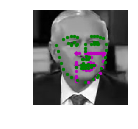

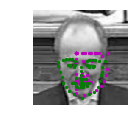

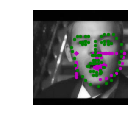

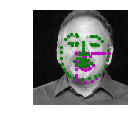

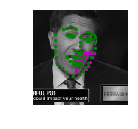

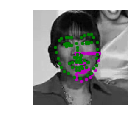

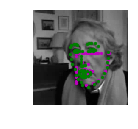

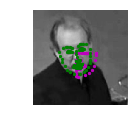

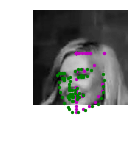

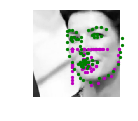

In [21]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [22]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_4.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:  For optimization, I tried with different optimizers on my local setup and I got the best result using Adam optimizer with a learning rate of 0.001. As this a regression problem so I choose a regression loss function i.e L1loss. L1 Loss Function helps to minimize the error which is the sum of all the absolute differences between the true value and the predicted value.  

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: At first, I tried with one conv2d layer with 136 nodes at the final layer. This architecture didn't go well then I stacked one more conv2d layer with the same architecture this start showing a little good result than previous. After then I thought of adding one more linear layer which unfortunately doesn't show the significant progress. Up to now for the linear layer; for the last conv2d layer I used adaptivemax2d pooling so that I should not do all the mathematical calculations. Then I thought of actually doing all the calculations and also adding one more conv2d layer. Now this works much better than previous architecture.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: The number of epochs is entirely an iterative based. In each epochs I look at loss, for the initial model, the model started overfitting too soon. But after I implement dropout in architecture overfitting was not the case now and the model's loss is linearly decreasing. I then realize the problem with architecture so I started changing the model and increase the epochs looking at both loss and test sample. for the batch size, I have tried a bunch of sizes like 1,8,16,32 on my local system i was astonised wheneven I use sizes like 64,32 udacity workspace crashes. I found the model is doing good at 16.  

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.15289958 -0.3003501   0.18335117]
 [ 0.00277038 -0.17118904 -0.25376728]
 [ 0.25633135 -0.07027665 -0.14474179]]
(3, 3)


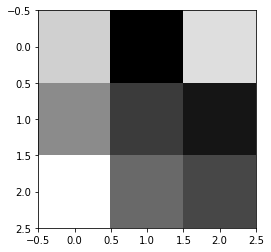

In [23]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


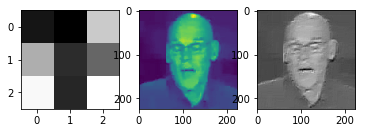

In [24]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2
dataiter = iter(test_loader)
sample = dataiter.next()
images = sample['image']
images = images.numpy()
id_= 15

img = np.squeeze(images[id_])


weights = net.conv2.weight.data
w = weights.numpy()

c = cv2.filter2D(img, -1, w[0][0])

f, ax = plt.subplots(1,3)
ax[0].imshow(w[0][0], cmap='gray')
ax[1].imshow(img)
ax[2].imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:The filter seems to focus on white area of the picture. As we can see the faces and also the words in the pictures are being focused on the photo.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!